Steps:
- Enable data augmentation, and precompute=True
- Use lr_find() to finmd highest learning rate where loss is clearly improving
- Train last layer from pre-computed activations for 1-2 epochs
- Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
- Unfreeze all layers
- Set earlier layers to 3x-10x lower learning rate than next higher layer
- Use lr_find() again
- Train full network with cycle=mult=2 until over-fitting

In [15]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [16]:
from sklearn import metrics
from fastai.conv_learner import *

In [3]:
PATH = 'data/dogcatbreed/'

In [4]:
bs=64
f_model = resnet50

In [5]:
# Data preparation steps if you are using Crestle:

os.makedirs('data/dogcatbreed/models', exist_ok=True)
os.makedirs('/cache/dogcatbreed/tmp', exist_ok=True)

In [6]:
label_csv= f'{PATH}train.csv'
n = len(list(open(label_csv))) - 1 #count row in file, exclude the header row
val_idxs = get_cv_idxs(n) # function choses random 20% data for valdation set

In [7]:
def get_data(sz, bs):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', bs=bs)

In [8]:
sz=224
data = get_data(sz,bs)

In [9]:
data = data.resize(int(sz*1.3), 'tmp')

In [10]:
learn = ConvLearner.pretrained(f_model, data, ps=0.5) #ps sets the dropout rate

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\nissan.dookeran/.torch\models\resnet50-19c8e357.pth
100%|███████████████████████████████████████████████████████████████| 102502400/102502400 [00:20<00:00, 5069253.06it/s]


 96%|███████████████████████████████████████████████████████████████████▉   | 88/92 [00:55<00:02,  1.60it/s, loss=20.6]

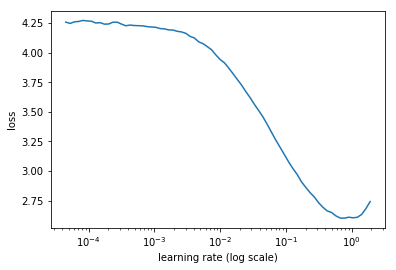

In [11]:
lrf=learn.lr_find()
learn.sched.plot()

In [12]:
lr = 1e-2

In [13]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      1.604883   0.558545   0.887679  
    1      1.050338   0.341724   0.899932                                                                              
    2      0.838398   0.313366   0.906059                                                                              
    3      0.781066   0.279565   0.911504                                                                              
    4      0.707266   0.265449   0.913547                                                                              
    5      0.666766   0.260171   0.91695                                                                               
    6      0.636852   0.256708   0.914908                                                                              


[array([0.25671]), 0.9149081007082337]

In [17]:
lrs = np.array([lr/9,lr/3,lr])

In [18]:
learn.unfreeze()
learn.bn_freeze(True)
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

  0%|                                                                                           | 0/92 [00:00<?, ?it/s]

RuntimeError: cuda runtime error (2) : out of memory at c:\anaconda2\conda-bld\pytorch_1519501749874\work\torch\lib\thc\generic/THCStorage.cu:58

In [ ]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

In [ ]:
learn.save(f'r50{sz}')

In [ ]:
learn.sched.plot_loss()

In [ ]:
sz=299

In [ ]:
learn.set_data(get_data(sz,bs))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

In [ ]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

In [ ]:
learn.save(f'r50{sz}')

# Run on test data now and create a submission

In [ ]:
log_preds,y = learn.TTA(is_test=True) #use test dataset not validation dataset
probs = np.mean(np.exp(log_preds),0)

In [ ]:
df = pd.DataFrame(probs)
df.columns = data.classes
df.insert(0, 'id', [o[5:-4] for o in data.test_ds.fnames])
df.head()

In [ ]:
SUBM = f'{PATH}/subm/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}fs3-subm1.gz', compression='gzip', index=False)
FileLink(f'{SUBM}fs3-subm1.gz')